In [73]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
!pip install pybbn
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2

In [74]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create bands for variables that we want to use in the model
df['Temp9amCat']=df['Temp9am'].apply(lambda x: 'cat1'   if x<15 else
                                                            'cat2' if 15<=x<=26 else 'cat3')
df['Temp3pmCat']=df['Temp3pm'].apply(lambda x: 'cat1'   if x<24 else
                                                            'cat2' if 24<=x<=36 else 'cat3')
df['WindSpeed9amCat']=df['WindSpeed9am'].apply(lambda x: 'cat1' if x<16 else 'cat2')
df['WindSpeed3pmCat']=df['WindSpeed3pm'].apply(lambda x: 'cat1' if x<15 else 'cat2')

# Show a snaphsot of data
df

<ipython-input-74-ad098525c9c5>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


Date    Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0      2008-12-01      Albury     13.4     22.9       0.6     5.616502   
1      2008-12-02      Albury      7.4     25.1       0.0     5.616502   
2      2008-12-03      Albury     12.9     25.7       0.0     5.616502   
3      2008-12-04      Albury      9.2     28.0       0.0     5.616502   
4      2008-12-05      Albury     17.5     32.3       1.0     5.616502   
...           ...         ...      ...      ...       ...          ...   
43365  2011-02-27  Wollongong     21.5     29.7       0.0     5.616502   
43366  2011-02-28  Wollongong     20.5     25.4       1.6     5.616502   
43367  2011-03-01  Wollongong     21.3     33.0       0.2     5.616502   
43368  2011-03-02  Wollongong     17.4     22.3       0.0     5.616502   
43369  2011-03-03  Wollongong     17.9     28.8       0.0     5.616502   

       Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0      7.584166           W           44.0          W        WNW   
1      7.584166         WNW           44.0        NNW        WSW   
2      7.584166         WSW           46.0          W        WSW   
3      7.584166          NE           24.0         SE          E   
4      7.584166           W           41.0        ENE         NW   
...         ...         ...            ...        ...        ...   
43365  7.584166         SSE           39.0        WNW         SE   
43366  7.584166         NNE           44.0          N        NNE   
43367  7.584166          SW           56.0        ESE          W   
43368  7.584166          SE           41.0        SSE          N   
43369  7.584166         NNW           41.0        WSW          N   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0              20.0          24.0         71.0         22.0       1007.7   
1               4.0          22.0         44.0         25.0       1010.6   
2              19.0          26.0         38.0         30.0       1007.6   
3              11.0           9.0         45.0         16.0       1017.6   
4               7.0          20.0         82.0         33.0       1010.8   
...             ...           ...          ...          ...          ...   
43365          15.0          11.0         57.0         55.0       1008.3   
43366           7.0          26.0         88.0         84.0       1010.7   
43367           4.0          15.0         68.0         31.0       1001.9   
43368          17.0           9.0         71.0         67.0       1017.8   
43369          15.0          11.0         50.0         51.0       1008.5   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0           1007.1  8.000000  4.395616     16.9     21.8        No   
1           1007.8  4.302228  4.395616     17.2     24.3        No   
2           1008.7  4.302228  2.000000     21.0     23.2        No   
3           1012.8  4.302228  4.395616     18.1     26.5        No   
4           1006.0  7.000000  8.000000     17.8     29.7        No   
...            ...       ...       ...      ...      ...       ...   
43365       1007.4  7.000000  1.000000     25.1     28.3        No   
43366       1007.5  8.000000  8.000000     21.3     23.3       Yes   
43367       1003.6  4.302228  4.395616     25.2     31.0        No   
43368       1015.4  7.000000  8.000000     18.7     20.2        No   
43369       1007.2  4.302228  4.395616     22.3     26.5        No   

      RainTomorrow Temp9amCat Temp3pmCat WindSpeed9amCat WindSpeed3pmCat  
0               No       cat2       cat1            cat2            cat2  
1               No       cat2       cat2            cat1            cat2  
2               No       cat2       cat1            cat2            cat2  
3               No       cat2       cat2            cat1            cat1  
4               No       cat2       cat2            cat1            cat2  
...            ...        ...        ...             ...             ...  
43365          Yes       cat

In [75]:
df['Temp9amCat'].value_counts(normalize=True).sort_index()

cat1    0.306023
cat2    0.654696
cat3    0.039282
Name: Temp9amCat, dtype: float64

In [76]:
df['Temp3pmCat'].value_counts(normalize=True).sort_index()

cat1    0.649097
cat2    0.329483
cat3    0.021420
Name: Temp3pmCat, dtype: float64

In [77]:
df['WindSpeed9amCat'].value_counts(normalize=True).sort_index()

cat1    0.662191
cat2    0.337809
Name: WindSpeed9amCat, dtype: float64

In [78]:
df['WindSpeed3pmCat'].value_counts(normalize=True).sort_index()

cat1    0.371089
cat2    0.628911
Name: WindSpeed3pmCat, dtype: float64

In [79]:
df['RainTomorrow'].value_counts(normalize=True).sort_index()

No     0.77413
Yes    0.22587
Name: RainTomorrow, dtype: float64

#3

In [80]:

# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob 

In [81]:
# Create nodes by using our earlier function to automatically calculate probabilities
Temp9am = BbnNode(Variable(0, 'Temp9am', ['cat1', 'cat2','cat3']), probs(df, child='Temp9amCat'))
Temp3pm = BbnNode(Variable(1, 'Temp3pm', ['cat1','cat2','cat3']), probs(df, child='Temp3pmCat', parent1='Temp9amCat'))
WindSpeed9am = BbnNode(Variable(2, 'WindSpeed9am', ['cat1','cat2']), probs(df, child='WindSpeed9amCat'))
WindSpeed3pm = BbnNode(Variable(3, 'WindSpeed3pm', ['cat1','cat2']), probs(df, child='WindSpeed3pmCat',parent1='WindSpeed9amCat'))
RainTomorrow = BbnNode(Variable(4, 'RainTomorrow', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Temp3pmCat', parent2='WindSpeed3pmCat'))

# Create NetWindSpeed9amork
bbn = Bbn() \
    .add_node(Temp9am) \
    .add_node(Temp3pm) \
    .add_node(WindSpeed9am) \
    .add_node(WindSpeed3pm)\
    .add_node(RainTomorrow) \
    .add_edge(Edge(Temp9am, Temp3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(Temp3pm, RainTomorrow, EdgeType.DIRECTED)) \
    .add_edge(Edge(WindSpeed9am, WindSpeed3pm, EdgeType.DIRECTED))\
    .add_edge(Edge(WindSpeed3pm, RainTomorrow, EdgeType.DIRECTED)) 

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

#4

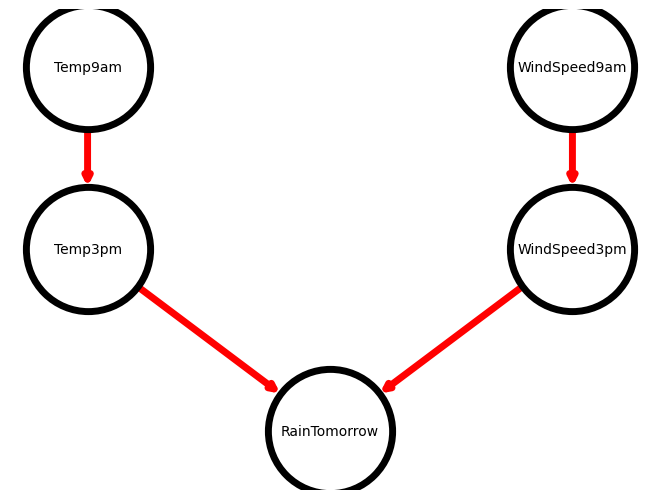

In [82]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 2), 3:(1,0.5) ,4:(0, -1)}

# Set options for graph looks
options = {
    "font_size": 10,
    "node_size": 8000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

#5

In [83]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.37109
3=cat2|0.62891
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|0.66219
2=cat2|0.33781
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|0.64910
1=cat2|0.32948
1=cat3|0.02142
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|0.30602
0=cat2|0.65470
0=cat3|0.03928
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.77409
4=Yes|0.22591
----------------


In [12]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
evidence('ev1', 'Temp9am', 'cat3', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.37109
3=cat2|0.62891
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|0.66219
2=cat2|0.33781
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|0.05495
1=cat2|0.56643
1=cat3|0.37862
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|0.00000
0=cat2|0.00000
0=cat3|1.00000
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.85697
4=Yes|0.14303
----------------


Since prob of not raining is 0.85697 which is greater than 0.5 our prediction is "It will not rain tomorrow"

In [24]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Add more evidence
evidence('ev2', 'Temp9am', 'cat1', 1.0)
# Print marginal probabilities
print_probs()

Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.37109
3=cat2|0.62891
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|0.66219
2=cat2|0.33781
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|0.97713
1=cat2|0.02287
1=cat3|0.00000
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|1.00000
0=cat2|0.00000
0=cat3|0.00000
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.73640
4=Yes|0.26360
----------------


Since prob of not raining is 0.73640 which is greater than 0.5 our prediction is "It will not rain tomorrow"

In [36]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
evidence('ev3', 'Temp3pm', 'cat2', 1.0)
print_probs()


Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.37109
3=cat2|0.62891
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|0.66219
2=cat2|0.33781
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|0.00000
1=cat2|1.00000
1=cat3|0.00000
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|0.02124
0=cat2|0.91123
0=cat3|0.06753
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.84576
4=Yes|0.15424
----------------


Since prob of not raining is 0.84576 which is greater than 0.5 our prediction is "It will not rain tomorrow"

In [84]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
evidence('ev4', 'Temp3pm', 'cat1', 1.0)
print_probs()


Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.37109
3=cat2|0.62891
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|0.66219
2=cat2|0.33781
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|1.00000
1=cat2|0.00000
1=cat3|0.00000
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|0.46068
0=cat2|0.53600
0=cat3|0.00333
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.73384
4=Yes|0.26616
----------------


Since prob of not raining is 0.73384 which is greater than 0.5 our prediction is "It will not rain tomorrow"

In [60]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
evidence('ev5', 'WindSpeed9am', 'cat1', 1.0)
print_probs()


Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.46755
3=cat2|0.53245
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|1.00000
2=cat2|0.00000
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|0.64910
1=cat2|0.32948
1=cat3|0.02142
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|0.30602
0=cat2|0.65470
0=cat3|0.03928
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.77750
4=Yes|0.22250
----------------


Since prob of not raining is 0.77750 which is greater than 0.5 our prediction is "It will not rain tomorrow"

In [72]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
evidence('ev6', 'WindSpeed3pm', 'cat2', 1.0)
print_probs()


Node: 3|WindSpeed3pm|cat1,cat2
Values:
3=cat1|0.00000
3=cat2|1.00000
----------------
Node: 2|WindSpeed9am|cat1,cat2
Values:
2=cat1|0.56063
2=cat2|0.43937
----------------
Node: 1|Temp3pm|cat1,cat2,cat3
Values:
1=cat1|0.64910
1=cat2|0.32948
1=cat3|0.02142
----------------
Node: 0|Temp9am|cat1,cat2,cat3
Values:
0=cat1|0.30602
0=cat2|0.65470
0=cat3|0.03928
----------------
Node: 4|RainTomorrow|No,Yes
Values:
4=No|0.76100
4=Yes|0.23900
----------------


Since prob of not raining is 0.76100 which is greater than 0.5 our prediction is "It will not rain tomorrow"